# Reguralization (Dropout, Normalization)
> ## 1. Library

> ## 2. MLP naive setting & Pre-process data

> ## 3. MLP batch norm
>> ### 3.1 with test phase
>> ### 3.2 with train, test phase

> ## 4. Dropout

> ## 5. Batch norm & Dropout

# Library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("device: gpu") if torch.cuda.is_available() else print("device: cpu")

device: gpu


# Hyper parameter setting

In [3]:
# hypter parameter setting
learning_rate = 1e-1
epochs = 30
# batch_size = 60000 # gradient descent
# batch_size = 1 # stochastic gradient descent
batch_size = 32 # mini-batch stochastic gradient descent
act = nn.Tanh()
h = 200
display_step = 5

# Load data & Pre-process data

len(train_data):  60000
len(test_data):  10000
original data shape:  torch.Size([1, 28, 28])
label:  5


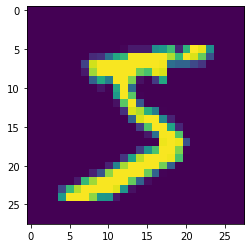

processed data shape: torch.Size([32, 1, 28, 28])
label: tensor([6, 1, 7, 2, 7, 7, 6, 5, 0, 0, 4, 5, 5, 8, 2, 3, 9, 6, 8, 9, 3, 5, 8, 5,
        2, 5, 3, 1, 4, 4, 8, 8])


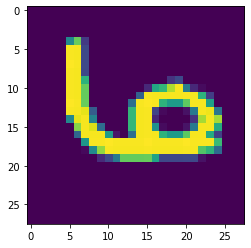

In [4]:
# load data
train_data = dataset.MNIST("./", train = True, transform = transforms.ToTensor(), target_transform = None, download = True)
test_data = dataset.MNIST("./", train = False, transform = transforms.ToTensor(), target_transform = None, download = True)

# check the data
print('len(train_data): ', len(train_data))
print('len(test_data): ', len(test_data))

x_train, y_train = train_data[0]
print('original data shape: ', x_train.shape)
print('label: ', y_train)

plt.figure()
plt.imshow(x_train[0])
plt.show()

# Pre-process (batch, shuffle)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 10000, shuffle = True, num_workers = 1, drop_last = True)

# check the data 
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print('processed data shape:', example_data.shape)
print('label:', example_target)

plt.figure()
plt.imshow(example_data[0][0])
plt.show()

# Model & Optimization and Loss function

In [5]:
# model
model = nn.Sequential(
        nn.Linear(np.prod(x_train.shape[1:]),1024),
        act,
        nn.Linear(1024,300),
        act,
        nn.Linear(300,10)
        )

model = model.to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# Train & Test

In [6]:
loss_array = []
iteration_loss_array = []

# train the model
for epoch in range(epochs):
    for iteration, [data, label] in enumerate(train_loader):
        optimizer.zero_grad()
        
        x = data.to(device)
        x = x.view(batch_size, -1)
        y = label.to(device)
        
        output = model(x)

        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()
        iteration_loss_array.append(loss.cpu().detach().numpy())
            
    loss_array.append(loss.cpu().detach().numpy())
    
    if epoch % 5 == 0:
        print("Epoch:", epoch + 1, "\Loss:", loss)

# test
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

Epoch: 1 \Loss: tensor(0.1555, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 6 \Loss: tensor(0.1244, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 11 \Loss: tensor(0.0067, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 16 \Loss: tensor(0.0023, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 21 \Loss: tensor(0.0509, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 26 \Loss: tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward>)
total 10000
correct tensor(9817., device='cuda:0')
accuracy tensor(0.9817, device='cuda:0')


## Plot result & Confusion matrix

In [8]:
# !pip install sklearn

     |████████████████████████████████| 6.8 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 15.5 MB/s eta 0:00:01
     |████████████████████████████████| 25.8 MB 7.6 MB/s eta 0:00:012     |█████████████████████████████▎  | 23.6 MB 4.8 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=70e341557ae1bc4414b74fffa212254dc367e52ae149729114c1b529eec6f383
  Stored in directory: /home/piai/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


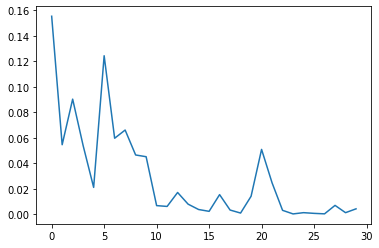

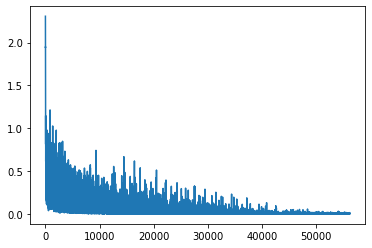

prediction : (10000,)
true label : (10000,)


array([[ 973,    0,    1,    1,    1,    1,    2,    1,    0,    0],
       [   0, 1124,    2,    2,    0,    1,    2,    1,    3,    0],
       [   4,    0, 1010,    5,    1,    0,    2,    6,    4,    0],
       [   0,    0,    2,  993,    1,    3,    0,    4,    4,    3],
       [   0,    0,    0,    1,  961,    1,    5,    2,    0,   12],
       [   3,    0,    0,    8,    2,  869,    5,    0,    2,    3],
       [   3,    2,    1,    0,    4,    4,  940,    0,    4,    0],
       [   2,    3,    6,    2,    2,    0,    0, 1005,    2,    6],
       [   2,    0,    2,    3,    1,    3,    1,    2,  958,    2],
       [   1,    2,    0,    4,    9,    2,    0,    5,    2,  984]])

In [7]:
# plot losses
plt.figure()
plt.plot(loss_array)
plt.show()
# plot iteration losses
plt.figure()
plt.plot(iteration_loss_array)
plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

# Build FC Layer Model
## (Show inner distribution)

In [8]:
# model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = 1024
        self.hidden2 = 300
        self.final = 10

        self.fc1 = nn.Linear(784, self.hidden1)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(self.hidden1, self.hidden2)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(self.hidden2, self.final)

    def forward(self, x):
        output1 = self.fc1(x)
        hidden1 = self.act1(output1)

        output2 = self.fc2(hidden1)
        hidden2 = self.act2(output2)
        
        logit = self.fc3(hidden2)
        
        return output1, hidden1, output2, hidden2, logit

model = MLP().to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# Train & Test

In [9]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        data = data.view(batch_size, -1)
        output1, hidden1, output2, hidden2, logit = model.forward(data)
        loss = loss_function(logit, label)
        loss.backward()
        optimizer.step()
        
    loss_array.append(loss.cpu().detach().numpy())

    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        
# test
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        output1, hidden1, output2, hidden2, prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

0 epoch loss: 0.37169188261032104
5 epoch loss: 0.15690180659294128
10 epoch loss: 0.019328201189637184
15 epoch loss: 0.007254998665302992
20 epoch loss: 0.009144747629761696
25 epoch loss: 0.0005418533110059798
total 10000
correct tensor(9826., device='cuda:0')
accuracy tensor(0.9826, device='cuda:0')


## Plot result

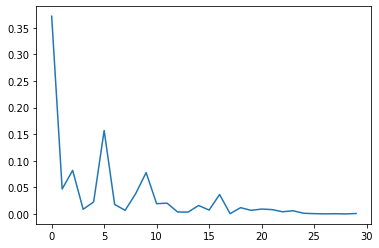

prediction : (10000,)
true label : (10000,)


array([[ 972,    0,    1,    1,    1,    2,    1,    1,    0,    1],
       [   0, 1126,    2,    1,    0,    1,    2,    1,    2,    0],
       [   4,    0, 1012,    4,    1,    0,    3,    3,    5,    0],
       [   1,    0,    4,  993,    0,    3,    0,    1,    3,    5],
       [   0,    0,    4,    0,  966,    0,    1,    2,    0,    9],
       [   5,    0,    0,    9,    1,  867,    4,    1,    3,    2],
       [   3,    1,    1,    1,    4,    3,  944,    0,    1,    0],
       [   1,    2,    5,    1,    1,    0,    0, 1012,    1,    5],
       [   4,    0,    2,    2,    1,    3,    1,    4,  955,    2],
       [   2,    2,    0,    6,    8,    2,    0,    7,    3,  979]])

In [10]:
plt.figure()
plt.plot(loss_array)
plt3.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

## Show inner distribution

torch.Size([10000, 784]) torch.Size([10000, 1024]) torch.Size([10000, 1024]) torch.Size([10000, 300]) torch.Size([10000, 300])


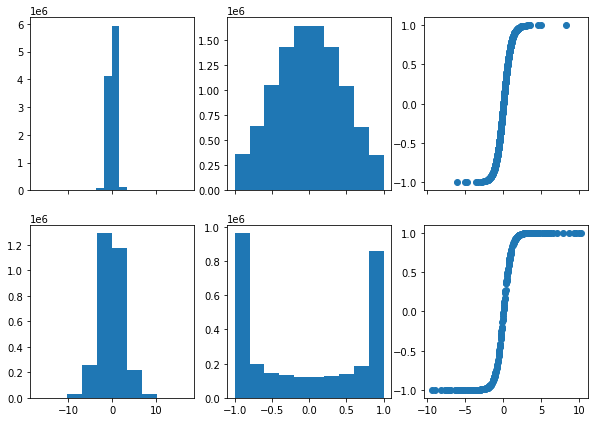

In [11]:
print(x.shape, output1.shape, hidden1.shape, output2.shape, hidden2.shape)

def plot_inner_dist(x, o1, h1, o2, h2):
    fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex='col')
    axs[0, 0].hist(o1.reshape(-1))
    axs[0, 1].hist(h1.reshape(-1))
    axs[0, 2].scatter(o1[0], h1[0])
    
    axs[1, 0].hist(o2.reshape(-1))
    axs[1, 1].hist(h2.reshape(-1))
    axs[1, 2].scatter(o2[0], h2[0])
    plt.show()
plot_inner_dist(x.cpu().numpy(), output1.cpu().numpy(), 
                hidden1.cpu().numpy(), output2.cpu().numpy(), hidden2.cpu().numpy())

# Add Batch Normalize Layers

In [12]:
# model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = 1024
        self.hidden2 = 300
        self.final = 10

        self.fc1 = nn.Linear(784, self.hidden1)
        self.bn1 = nn.BatchNorm1d(self.hidden1)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(self.hidden1, self.hidden2)
        self.bn2 = nn.BatchNorm1d(self.hidden2)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(self.hidden2, self.final)

    def forward(self, x):
        output1 = self.fc1(x)
        bn1 = self.bn1(output1)
        hidden1 = self.act1(bn1)

        output2 = self.fc2(hidden1)
        bn2 = self.bn2(output2) # 액티베이션 전에 배치노말라이제이션 함
        hidden2 = self.act2(bn2)
        
        logit = self.fc3(hidden2)
        
        return output1, hidden1, output2, hidden2, logit

model = MLP().to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# Train & Test

In [15]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        data = data.view(batch_size, -1)
        output1, hidden1, output2, hidden2, logit = model.forward(data)
        loss = loss_function(logit, label)
        loss.backward()
        optimizer.step()
        
    loss_array.append(loss.cpu().detach().numpy())
    
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        
        
# test
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        output1, hidden1, output2, hidden2, prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

0 epoch loss: 0.13499917089939117
5 epoch loss: 0.028773145750164986
10 epoch loss: 0.0029729113448411226
15 epoch loss: 0.0002784520329441875
20 epoch loss: 0.00238997139967978
25 epoch loss: 0.0002593646349851042
total 10000
correct tensor(9839.)
accuracy tensor(0.9839)


## Plot the result

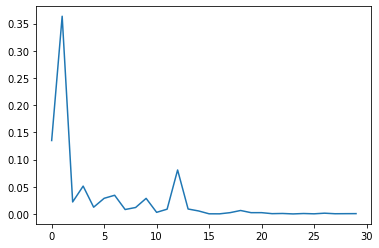

prediction : (10000,)
true label : (10000,)


array([[ 971,    1,    3,    0,    0,    1,    2,    1,    0,    1],
       [   1, 1127,    2,    1,    0,    0,    1,    1,    2,    0],
       [   3,    1, 1015,    1,    1,    0,    0,    6,    4,    1],
       [   1,    0,    8,  986,    0,    3,    0,    4,    6,    2],
       [   1,    0,    0,    1,  966,    0,    5,    1,    1,    7],
       [   2,    0,    0,    9,    1,  868,    6,    3,    2,    1],
       [   3,    1,    3,    0,    2,    3,  945,    0,    1,    0],
       [   0,    0,    5,    0,    1,    0,    0, 1016,    2,    4],
       [   2,    0,    0,    2,    2,    2,    0,    1,  961,    4],
       [   2,    3,    0,    4,    7,    2,    0,    5,    2,  984]])

In [16]:
plt.figure()
plt.plot(loss_array)
plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

## Show inner distribution

torch.Size([10000, 784]) torch.Size([10000, 1024]) torch.Size([10000, 1024]) torch.Size([10000, 300]) torch.Size([10000, 300])


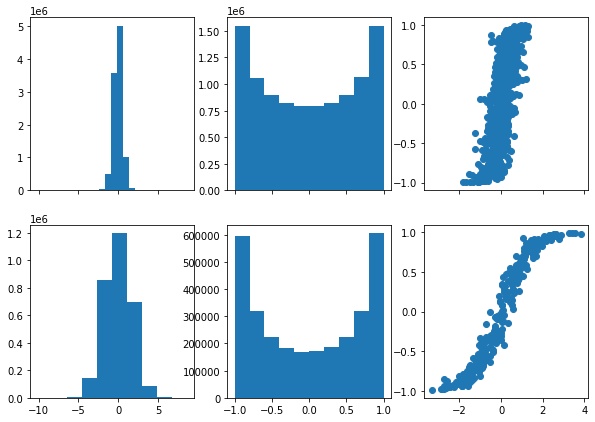

In [17]:
print(x.shape, output1.shape, hidden1.shape, output2.shape, hidden2.shape)

def plot_inner_dist(x, o1, h1, o2, h2):
    fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex='col')
    axs[0, 0].hist(o1.reshape(-1))
    axs[0, 1].hist(h1.reshape(-1))
    axs[0, 2].scatter(o1[0], h1[0])
    axs[1, 0].hist(o2.reshape(-1))
    axs[1, 1].hist(h2.reshape(-1))
    axs[1, 2].scatter(o2[0], h2[0])
    plt.show()

plot_inner_dist(x.cpu().numpy(), output1.cpu().numpy(), 
                hidden1.cpu().numpy(), output2.cpu().numpy(), hidden2.cpu().numpy())

In [ ]:
# 배치노말라이제이션 이후 0에 집약됨. -> 그래디언트 소실문제 보완

# Add Dropout Layers

In [18]:
# hyper parameter setting
learning_rate = 1e-1
epochs = 100
# batch_size = 60000 # gradient descent
# batch_size = 1 # stochastic gradient descent
batch_size = 32 # mini-batch stochastic gradient descent
act = nn.Tanh()
h = 200
display_step = 10
dropout_rate = .2 # probability to be 0 / 각각의 노드가 꺼질 확률

In [19]:
# model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = 1024
        self.hidden2 = 300
        self.final = 10

        self.fc1 = nn.Linear(784, self.hidden1)
        self.act1 = nn.Tanh()
        self.drop1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(self.hidden1, self.hidden2)
        self.act2 = nn.Tanh()
        self.drop2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(self.hidden2, self.final)

    def forward(self, x):
        output1 = self.fc1(x)
        hidden1 = self.act1(output1)
        drop1 = self.drop1(hidden1)
        
        output2 = self.fc2(drop1)
        hidden2 = self.act2(output2)
        drop2 = self.drop2(hidden2) # 아까와 다르게 액티베이션 함수 뒤에 드랍아웃 함
        
        logit = self.fc3(drop2)
        
        return logit

model = MLP().to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# Train & Test

In [20]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        data = data.view(batch_size, -1)
        logit = model.forward(data)
        loss = loss_function(logit, label)
        loss.backward()
        optimizer.step()
        
    loss_array.append(loss.cpu().detach().numpy())
    
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        
        
# test
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

0 epoch loss: 0.21708019077777863
10 epoch loss: 0.0022646277211606503
20 epoch loss: 0.0042423983104527
30 epoch loss: 0.003515404649078846
40 epoch loss: 0.001038988004438579
50 epoch loss: 0.030972078442573547
60 epoch loss: 0.00045486848102882504
70 epoch loss: 0.00012559257447719574
80 epoch loss: 2.990920256706886e-05
90 epoch loss: 0.0002600516891106963
total 10000
correct tensor(9830.)
accuracy tensor(0.9830)


## Plot result

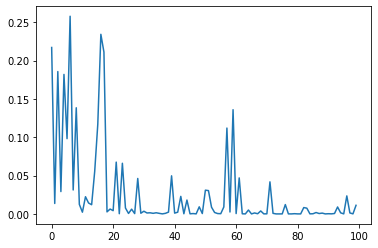

prediction : (10000,)
true label : (10000,)


array([[ 974,    0,    0,    1,    0,    1,    0,    1,    3,    0],
       [   0, 1127,    2,    2,    0,    1,    2,    1,    0,    0],
       [   4,    2, 1014,    1,    2,    0,    2,    5,    2,    0],
       [   0,    0,    1,  994,    0,    0,    0,    5,    5,    5],
       [   0,    0,    3,    0,  962,    0,    4,    2,    0,   11],
       [   3,    0,    0,    8,    2,  868,    3,    1,    4,    3],
       [   4,    2,    1,    1,    3,    2,  943,    0,    2,    0],
       [   1,    4,    7,    1,    3,    0,    0, 1005,    2,    5],
       [   0,    1,    2,    2,    1,    3,    0,    4,  958,    3],
       [   2,    2,    0,    4,    9,    1,    0,    6,    0,  985]])

In [21]:
plt.figure()
plt.plot(loss_array)
plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

# Add Batch norm, Dropout Layers

In [22]:
# model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = 1024
        self.hidden2 = 300
        self.final = 10

        self.fc1 = nn.Linear(784, self.hidden1)
        self.bn1 = nn.BatchNorm1d(self.hidden1)
        self.act1 = nn.Tanh()
        self.drop1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(self.hidden1, self.hidden2)
        self.bn2 = nn.BatchNorm1d(self.hidden2)
        self.act2 = nn.Tanh()
        self.drop2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(self.hidden2, self.final)

    def forward(self, x):
        output1 = self.fc1(x)
        bn1 = self.bn1(output1)
        hidden1 = self.act1(bn1)
        drop1 = self.drop1(hidden1)

        output2 = self.fc2(drop1)
        bn2 = self.bn2(output2)
        hidden2 = self.act2(bn2)
        drop2 = self.drop2(hidden2)
        
        logit = self.fc3(drop2)
        
        return logit

model = MLP().to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# Train & Test

In [23]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        data = data.view(batch_size, -1)
        logit = model.forward(data)
        loss = loss_function(logit, label)
        loss.backward()
        optimizer.step()
        
    loss_array.append(loss.cpu().detach().numpy())
    
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        
        
# test
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

0 epoch loss: 0.26784875988960266
10 epoch loss: 0.14367887377738953
20 epoch loss: 0.011898941360414028
30 epoch loss: 0.01766960136592388
40 epoch loss: 0.001021892880089581
50 epoch loss: 0.000501427159179002
60 epoch loss: 0.014040084555745125
70 epoch loss: 1.2127971785957925e-05
80 epoch loss: 0.00046532167471013963
90 epoch loss: 0.0003185016685165465
total 10000
correct tensor(9861.)
accuracy tensor(0.9861)


## Plot result

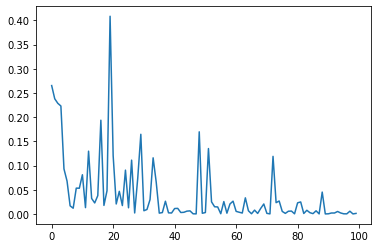

prediction : (10000,)
true label : (10000,)


array([[ 974,    1,    2,    0,    0,    1,    0,    1,    1,    0],
       [   1, 1125,    3,    0,    0,    0,    2,    1,    3,    0],
       [   1,    1, 1020,    2,    0,    0,    1,    3,    3,    1],
       [   0,    0,    2,  997,    0,    2,    0,    4,    3,    2],
       [   2,    0,    1,    1,  965,    0,    4,    0,    1,    8],
       [   2,    0,    0,   10,    1,  870,    4,    1,    3,    1],
       [   3,    2,    1,    1,    2,    3,  946,    0,    0,    0],
       [   0,    3,    9,    2,    0,    0,    0, 1011,    2,    1],
       [   2,    1,    2,    2,    2,    4,    0,    2,  957,    2],
       [   3,    3,    0,    7,    5,    1,    0,    2,    2,  986]],
      dtype=int64)

In [21]:
plt.figure()
plt.plot(loss_array)
plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

# Advanced: batch norm + dropout in CNN

In [22]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)

# batchnorm + dropout in CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding =1), # 28 x 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16, 32, 3, padding =1), # 14 x 14 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2) # 7 x 7
        )
        self.classifier = nn.Sequential(
            nn.Linear(32*7*7,100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(100,10)
        )
    def forward(self, x):
        feature_extraction = self.feature_extraction(x)
        flatten = feature_extraction.view(batch_size, -1)         
        logit = self.classifier(flatten)
        
        return logit
        
model = CNN().to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# Train & Test

In [23]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        loss_array.append(loss.cpu().detach().numpy())
        
#test the model
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for index, [data, label] in enumerate(test_loader):
        data = data.to(device)
        label = label.to(device)
        
        output = model.forward(data)
        _, prediction_index = torch.max(output, 1)
        
        prediction_list.append(prediction_index)
        label_list.append(label)
        
        total += label.size(0)
        correct += (prediction_index == label).sum().float()

    print("Accuracy of the model: {}".format(correct/total))

0 epoch loss: 0.192315936088562
10 epoch loss: 0.03905729949474335
20 epoch loss: 0.0023034662008285522
30 epoch loss: 7.680058479309082e-05
40 epoch loss: 1.1265277862548828e-05
50 epoch loss: 0.0001609325408935547
60 epoch loss: 2.5987625122070312e-05
70 epoch loss: 7.331371307373047e-06
80 epoch loss: 9.447336196899414e-06
90 epoch loss: 0.002233251929283142
Accuracy of the model: 0.9931890964508057
